In [1]:
from bs4 import BeautifulSoup
import requests
import copy
import re
import pickle
from collections import defaultdict
import sys
import matplotlib
import matplotlib.pyplot as plt
sys.setrecursionlimit(40000) # to enable pickle to handle the dictionary load

In [2]:
# retrieve actors list
def get_actors_list(tag, style):
    dirty_actors_list = list(soup.findAll(tag, style=style)) # find & assign the big 'paragraph' to a variable
    clean_actors_list = []
    for line in dirty_actors_list:
        clean_actors_list.append(line.a.string) # .a picks up the specific string (name)
    return clean_actors_list

In [3]:
def get_bankability_metrics(tag, style):

    # primary bankability metrics________________________________________________
    dirty_bank_list = list(soup.findAll(tag, style=style)) # find & assign the big 'paragraph' to a variable
    clean_bank_list = []
    for line in dirty_bank_list:
        # retrieve bankability as a string with commas; remove them along with $, then convert to integer
        clean_bank_list.append(int(line.text[1:].replace(',','')))
    # print(clean_bank_list) # test-print

    # secondary bankability metrics________________________________________________
    movs_per_yr_list = []
    bank_per_yr_list = []
    bank_per_mov_list = []
    for n in dirty_bank_list:
        string_container = n.nextSibling.nextSibling.get_text()
        # print(string_container, "END \n")  # temp
        # parse through loop and retrieve movies per year for each actor
        divider1 = string_container.find(" movies/year")
        movs_per_yr_list.append(float(string_container[2:divider1]))
        # parse through loop to retrieve bankability per year for each actor
        divider2 = string_container.find("/year", divider1) + divider1
        divider3 = string_container.find("/year", divider2 + divider1)
        bank_per_yr_list.append(int(string_container[divider2 + divider1:divider3].replace(',', '')))
        # it turns out that the main bankability number is calculated this way- so we're back where we started!
        #bank_per_mov_list.append(bank_per_yr_list[-1] / movs_per_yr_list[-1])
    
    # test-prints______________________________________
    # print("movs_per_yr:", movs_per_yr_list, len(movs_per_yr_list))
    # print(bank_per_yr_list, len(bank_per_yr_list))
    # print(bank_per_mov_list, len(bank_per_mov_list))
    return clean_bank_list, movs_per_yr_list


In [4]:
# Primary Roles________________________________________________
def get_roles_in_films(identifier):
    films_dict = defaultdict(list)
    rank = 1
    # print('length = ', len(list(soup.find_all(id="col2mid")))) # temp
    for l in list(soup.find_all(id=identifier)):
        for r in list(re.findall(r'summary">(.*?)<', str(l))):
            # attempting to replace gibberish chars with appropriate apostrophes and colons
            if r.find('â') != -1:                                           # if r contains an a-hat
                if r[r.find('â')+3] == 's':                                    # if it's actually 's
                    r = r[:r.find('â')]+"'"+r[r.find('â')+3:] # remove special chars and insert an '
                else:
                    r = r[:r.find('â')]+":"+r[r.find('â')+2:]  # remove special chars and insert a :
            if r.find('Galaxy Vol') != -1:              # to manually fix Vol vs Vol. in Guardians 2
                r = r.replace('Vol', 'Vol.')
            if r.find('Detective Pikachu') != -1:       # to manually fix Pokemon Detective Pikachu
                r = "Pokemon Detective Pikachu"
            if r not in films_dict[str(rank)]: # check if duplicate, skip if it is
                films_dict[str(rank)].append(r)
        rank +=1
    return films_dict

In [5]:
# MAIN CODE _____________________________________________________
# GET and prettify via Beautiful Soup
html_page = requests.get("https://www.the-numbers.com/bankability") #Make a get request to retrieve the page
soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing
# soup.prettify # test-print

actors_list = []
actors_list = get_actors_list('span', "font-size:200%;")                         # function to get names
bank_list, films_per_yr_list = get_bankability_metrics('div', "font-size:200%;") # function to get metrics
roles_in_films_dict = get_roles_in_films("col2mid")                              # function to get films

# put it all together____________________________
main_dict = {}
attributes = {}
if len(actors_list) == len(bank_list): # make sure they're both 50 elements long, else raise an error
    for i in range(len(actors_list)):
        attributes['rank'] = i+1                            # assign rank to this row
        attributes['bankability'] = bank_list[i]            # assign bankability to this row
        attributes['movies_per_yr'] = films_per_yr_list[i]  # assign films per year to this row
        attributes['roles'] = roles_in_films_dict[str(i+1)] # assign films to this row
        main_dict[actors_list[i]] = attributes.copy()       # add to main_dict- use copy, the pointers change!
else:
    raise ValueError
main_dict # test-print


movs_per_yr: [1.1, 1.1, 1.4, 1.0, 1.3, 1.1, 1.2, 1.2, 1.2, 2.2, 1.8, 1.3, 2.9, 2.1, 1.3, 2.0, 1.0, 1.5, 2.5, 1.0, 1.2, 2.2, 1.5, 2.2, 1.2, 1.2, 2.4, 2.6, 2.7, 1.9, 1.0, 2.3, 1.3, 1.1, 4.4, 1.9, 2.8, 1.3, 1.7, 1.4, 1.9, 2.0, 1.3, 2.1, 1.8, 1.3, 2.7, 3.0, 1.9, 2.0] 50


{'Tom Cruise': {'rank': 1,
  'bankability': 22537572,
  'movies_per_yr': 1.1,
  'roles': ['Mission: Impossible:\x94Fallout',
   'Mission: Impossible:\x94Rogue Nation',
   'Mission: Impossible:\x94Ghost Protocol',
   'War of the Worlds',
   'Austin Powers in Goldmember',
   'Mission: Impossible 2',
   'Mission: Impossible III']},
 'Will Smith': {'rank': 2,
  'bankability': 20593743,
  'movies_per_yr': 1.1,
  'roles': ['Aladdin',
   'Suicide Squad',
   'I am Legend',
   'Hancock',
   'Men in Black 3',
   'Hitch',
   'The Pursuit of Happyness',
   'Annie',
   'I, Robot']},
 'Robert Downey, Jr.': {'rank': 3,
  'bankability': 16602313,
  'movies_per_yr': 1.4,
  'roles': ['Avengers: Endgame',
   'Avengers: Infinity War',
   'The Avengers',
   'Avengers: Age of Ultron',
   'Captain America: Civil War',
   'The Judge',
   'A Guide to Recognizing Your Saints']},
 'Sandra Bullock': {'rank': 4,
  'bankability': 15694181,
  'movies_per_yr': 1.0,
  'roles': ['Minions',
   'Gravity',
   'The Blind S

In [6]:
# Save & Store File (Pickle)
filename = "actors_dict"
outfile = open(filename, 'wb')

In [7]:
pickle.dump(main_dict, outfile)
outfile.close()

In [8]:
# Retrieve File (Un-pickle)
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()

In [9]:
# confirm it's loaded accurately
print(new_dict)
print(new_dict==main_dict)
print(type(new_dict))

{'Tom Cruise': {'rank': 1, 'bankability': 22537572, 'movies_per_yr': 1.1, 'roles': ['Mission: Impossible:\x94Fallout', 'Mission: Impossible:\x94Rogue Nation', 'Mission: Impossible:\x94Ghost Protocol', 'War of the Worlds', 'Austin Powers in Goldmember', 'Mission: Impossible 2', 'Mission: Impossible III']}, 'Will Smith': {'rank': 2, 'bankability': 20593743, 'movies_per_yr': 1.1, 'roles': ['Aladdin', 'Suicide Squad', 'I am Legend', 'Hancock', 'Men in Black 3', 'Hitch', 'The Pursuit of Happyness', 'Annie', 'I, Robot']}, 'Robert Downey, Jr.': {'rank': 3, 'bankability': 16602313, 'movies_per_yr': 1.4, 'roles': ['Avengers: Endgame', 'Avengers: Infinity War', 'The Avengers', 'Avengers: Age of Ultron', 'Captain America: Civil War', 'The Judge', 'A Guide to Recognizing Your Saints']}, 'Sandra Bullock': {'rank': 4, 'bankability': 15694181, 'movies_per_yr': 1.0, 'roles': ['Minions', 'Gravity', 'The Blind Side', "Ocean's 8", 'The Heat', 'The Proposal', 'Miss Congeniality', 'Two Weeks Notice', 'Miss

In [10]:
import config
import mysql.connector ## Connect to DB server on AWS

## connecting to the database using 'connect()' method
## it takes 3 required parameters 'host', 'user', 'passwd'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = "Movie Project1"
)

cursor = cnx.cursor()
print(cnx) # confirm MySQL connection

In [82]:
# BE CAREFUL WITH THIS KERNEL!  INSERTS MORE ROWS IN SQL DB___________________________
for actor in main_dict:
    for i in range(len(main_dict[actor]['roles'])):
        # INSERT INDIVIDUALLY
        # print(type(actor), type(main_dict[actor]['bankability']), type(main_dict[actor]['roles'][i]))
        add_actor_line = ("INSERT INTO Actors "
               "(name, bankability, title, movies_per_yr) "
               "VALUES (%s, %s, %s, %s)")
        data_actor_line = (str(actor), 
                           main_dict[actor]['bankability'], 
                           main_dict[actor]['roles'][i], 
                           main_dict[actor]['movies_per_yr'])
        # Insert new actor line
        cursor.execute(add_actor_line, data_actor_line)

cnx.commit()

In [11]:
'''query2 = ("""SELECT Genres.genre, Genres.budget, ROUND(AVG(Reviews.ratings), 2)
            FROM Genres JOIN Reviews ON Genres.title LIKE Reviews.title
            GROUP BY Genres.title ORDER BY Genres.boxoffice DESC""")
'''

query1a = ("""SELECT Genres.genre, Genres.boxoffice, ROUND(AVG(Reviews.ratings), 2), COUNT(Actors.name)
                FROM Genres 
                JOIN Reviews USING (title)
                LEFT JOIN Actors USING (title)
                GROUP BY Genres.title ORDER BY Genres.boxoffice DESC""")
bo_3d, bo_romcom, bo_ani, bo_ho, bo_gl = [],[],[],[],[]       # create containers to hold each genre's boxoffice 
rat_3d, rat_romcom, rat_ani, rat_ho, rat_gl = [],[],[],[],[] # create containers to hold each genre's avg rating 
bc_3d, bc_romcom, bc_ani, bc_ho, bc_gl = [],[],[],[],[]  # create containers to hold each genre's count of top50 

cursor.execute(query1a)
for (genre, dollars, rating, bankcount) in cursor:
    if genre == '3D':
        bo_3d.append(dollars)
        rat_3d.append(rating)
        bc_3d.append(bankcount*100)
    elif genre == 'Rom-Com':
        bo_romcom.append(dollars)
        rat_romcom.append(rating)
        bc_romcom.append(bankcount*100)
    elif genre == 'Animation':
        bo_ani.append(dollars)
        rat_ani.append(rating)
        bc_ani.append(bankcount*100)
    elif genre == 'Horror':
        bo_ho.append(dollars)
        rat_ho.append(rating)
        bc_ho.append(bankcount*100)
    elif genre == 'Gay/Lesbian':
        bo_gl.append(dollars)
        rat_gl.append(rating)
        bc_gl.append(bankcount*100)
    else:
        print("ALERT!!!!")
# confirm each row's lists match in length
print('3d:', len(bo_3d), len(rat_3d), len(bc_3d),'\n')
print('romcom:', len(bo_romcom), len(rat_romcom), len(bc_romcom),'\n')
print('ani:', len(bo_ani), len(rat_ani), len(bc_ani),'\n')
print('horror:', len(bo_ho), len(rat_ho), len(bc_ho),'\n')
print('gay:', len(bo_gl), len(rat_gl), len(bc_gl),'\n')

3d: 174 174 174 

romcom: 149 149 149 

ani: 110 110 110 

horror: 149 149 149 

gay: 33 33 33 



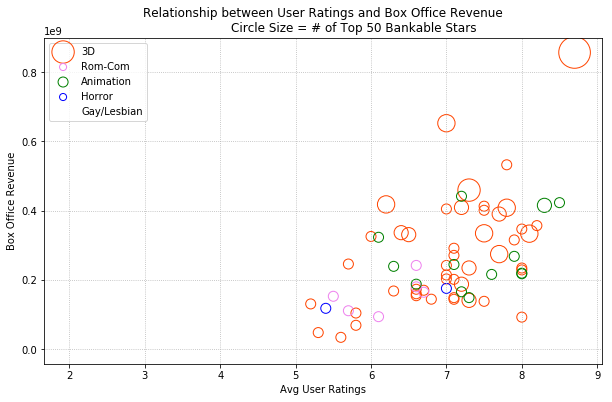

In [17]:
fig2, ax2 = plt.subplots(figsize = (10, 6))
# Add data: "height", "weight" as x-y, index as color
ax2.scatter(rat_3d, bo_3d, label='3D', s=bc_3d, facecolors='none', edgecolors='orangered')
ax2.scatter(rat_romcom, bo_romcom, label='Rom-Com', s=bc_romcom, facecolors='none', edgecolors='violet')
ax2.scatter(rat_ani, bo_ani, label='Animation', s=bc_ani, facecolors='none', edgecolors='g')
ax2.scatter(rat_ho, bo_ho, label='Horror', s=bc_ho, facecolors='none', edgecolors='b')
ax2.scatter(rat_gl, bo_gl, label='Gay/Lesbian', s=bc_gl, facecolors='none', edgecolors='r')
#ax.scatter(females["Height"], females["Weight"], label='Females',color ='b' )

# Set the x-axis label to "Height (cm)"
ax2.set_xlabel("Avg User Ratings")

# Set the y-axis label to "Weight (lbs)"
ax2.set_ylabel("Box Office Revenue")

ax2.set_title('Relationship between User Ratings and Box Office Revenue\n\
                Circle Size = # of Top 50 Bankable Stars')
ax2.grid(linestyle=':', linewidth='0.8')
ax2.legend()
plt.show()
fig2.savefig("ScatterPlot-Cross-Relationships.png", bbox_inches='tight')


In [13]:
query = ("SELECT DISTINCT name, bankability FROM Actors ")

actors, bank = [], []
cursor.execute(query)

for (name, bankability) in cursor:
    actors.append(name)
    bank.append(bankability)

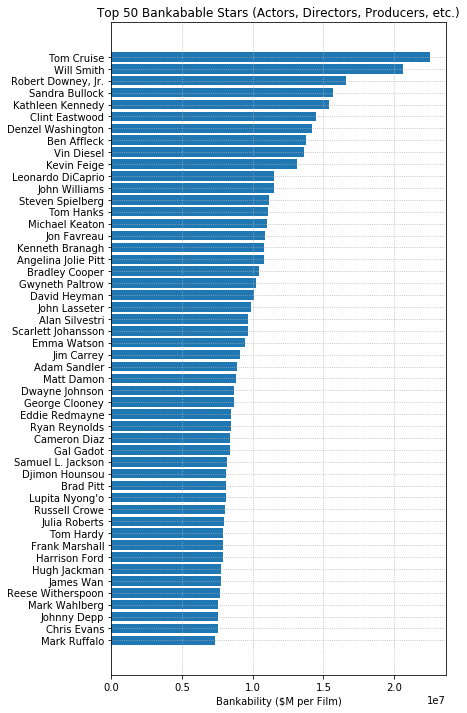

In [29]:
fig, ax = plt.subplots(figsize=(6, 12))

# Plot a bar-chart of gold medals as a function of country
ax.barh(actors, bank, height = 0.8)

# Set the x-axis tick labels to the country names
ax.set_yticklabels(actors, rotation=0)

# Set the y-axis label
ax.set_xlabel("Bankability ($M per Film)")

ax.set_title('Top 50 Bankabable Stars (Actors, Directors, Producers, etc.)')
plt.gca().invert_yaxis()
ax.grid(linestyle=':', linewidth='0.8')
plt.show()
fig.savefig("BarGraph_Bankability.png", bbox_inches='tight')


In [18]:
cursor.close()
cnx.close()